# [18] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [18.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import neighbors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

C:\Users\raj52\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative

In [3]:
print (filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [18.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
ORDER BY ProductID,UserId,Time
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150519,0006641040,A12HY5OZ2QNK4N,Elizabeth H. Roessner,0,0,5,1256774400,It's a great book!,I've always loved chicken soup and rice. My la...
1,150511,0006641040,A1C9K534BCI9GO,Laura Purdie Salas,0,0,4,1344211200,Charming and childlike,"A charming, rhyming book that describes the ci..."
2,150512,0006641040,A1DJXZA5V5FFVA,A. Conway,0,0,5,1338249600,Must have.,I set aside at least an hour each day to read ...
3,150497,0006641040,A1HKYQOFC8ZZCH,"Maria Apolloni ""lanarossa""",2,2,1,1334707200,"The story is great, the softcover book is disa...",I give five stars to the Maurice Sendak story....
4,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,5,1009324800,It Was a favorite!,This was a favorite book of mine when I was a ...
5,150522,0006641040,A1S3C5OFU508P3,Charles Ashbacher,0,0,4,1219536000,Children will find it entertaining and a gener...,This book contains a collection of twelve shor...
6,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
7,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,4,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...
8,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
9,150514,0006641040,A2ONB6ZA292PA,Rosalind Matzner,0,0,5,1313884800,Chicken soup with Rice,It's a great book with adorable illustrations....


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

## 18.1.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [12]:
#nltk.download('stopwords')
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'hers', 'can', 'same', 'having', 'here', "couldn't", 'mustn', 'both', 're', 'doesn', 'how', 'his', 'who', 'ours', 'should', 'by', 'have', 'them', 'nor', 'its', "she's", 'for', 'or', 'wasn', 'had', 'wouldn', "weren't", 'her', 'again', 'above', 'yours', 'where', "didn't", 'there', 'weren', 'i', 'you', "you'd", 's', 'is', 'your', 'very', 'during', 'she', 'more', "wasn't", "you'll", 'an', 'herself', 'being', 'below', 'until', 'because', "you've", 'through', 'most', 'not', "you're", 'about', 'ourselves', "needn't", 'from', 'aren', 'then', "that'll", 'once', 'o', 'isn', 'theirs', 'what', 'why', 'off', 'needn', 'me', 'which', 'ma', 'd', 'only', 'don', 'shan', "doesn't", 'against', 'any', 'other', 'will', 'this', 'their', "shan't", "won't", "mightn't", 't', 'to', 'yourselves', 'hasn', 'am', 'hadn', 've', 'my', 'the', "haven't", 'it', 'all', "should've", 'are', 'in', 'himself', "mustn't", 'those', 'with', 'into', 'he', 'while', "it's", 'over', 'did', 'few', 'didn', 'do', 'won', 'when', 'should

In [13]:
#removing stop words and html tags
#listing all words from potive and negative reviews
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [14]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [15]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [2]:
con = sqlite3.connect('final.sqlite') 

final = pd.read_sql_query(""" SELECT * FROM Reviews """, con) 

In [3]:
#Sampling first 200K Data-Points of 364K Data-Points
#after sorting by time

#sorting by time
final=final.sort_values('Time')

df_sampled=final[:200000]
print("The number of negative points and positive points are ",
      df_sampled[df_sampled['Score']=='negative'].shape[0]
     ,"&",df_sampled[df_sampled['Score']=='positive'].shape[0])

The number of negative points and positive points are  28460 & 171540


## [18.1.4] Slicing Data in D-Train and D-Test

In [4]:
# split the data set into train and test

from sklearn import model_selection as ms
y=df_sampled['Score']
dw_train,dw_test,y_train,y_test=ms.train_test_split(df_sampled, y, test_size=0.3, random_state=0)
print(dw_train.shape,dw_test.shape)

(140000, 12) (60000, 12)


# [18.2] Bag of Words (BoW)

In [5]:
#Build The Vocabulary
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(dw_train['CleanedText'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [6]:
#Vectorize train and test data

d_train = count_vect.transform(dw_train['CleanedText'].values)
print("the type of count vectorizer ",type(d_train))
print("the shape of train-text BOW vectorizer ",d_train.get_shape())

d_test = count_vect.transform(dw_test['CleanedText'].values)
print("the shape of test-text BOW vectorizer ",d_test.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train-text BOW vectorizer  (140000, 44198)
the shape of test-text BOW vectorizer  (60000, 44198)


## [18.2.1] Bag Of Words with Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [21]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [5]:
#building the vocabulary with uni-grams and bi-grams
#removing stop words like "not" should be avoided before building n-grams
count_vect_bg = CountVectorizer(ngram_range=(1,2))
count_vect_bg.fit(dw_train['CleanedText'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [6]:
#Vectorize train and test data
d_train_bg = count_vect_bg.transform(dw_train['CleanedText'].values)
print("the type of count vectorizer ",type(d_train_bg))
print("the shape of train-text BOW vectorizer ",d_train_bg.get_shape())

d_test_bg = count_vect_bg.transform(dw_test['CleanedText'].values)
print("the shape of test-text BOW vectorizer ",d_test_bg.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train-text BOW vectorizer  (140000, 1558580)
the shape of test-text BOW vectorizer  (60000, 1558580)


In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=0)
#without using bigram
d_train_dense=svd.fit_transform(d_train_bg)
print (svd.explained_variance_ratio_)
print (svd.explained_variance_ratio_.cumsum())

## [18.2.2] Multinomial Naive Bayes

In [9]:
import warnings
warnings.filterwarnings('ignore')

#defining alpha for grid-search
param= {'alpha':[0.001,0.01,1,10,100,1000,10000]}

#Using Grid Search to get Best Alpha

clf = GridSearchCV(MultinomialNB(), param, cv=5)
clf.fit(d_train, y_train)
print(" optimal value is " + str(clf.best_params_))
print()
optimal_alpha=clf.best_params_.get('alpha')

 optimal value is {'alpha': 1}



In [10]:
nb_bow=MultinomialNB(alpha=optimal_alpha)
nb_bow.fit(d_train,y_train)


MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [11]:
#Saving the model
from sklearn.externals import joblib
joblib.dump(nb_bow, 'nb_bow.pkl') 

['nb_bow.pkl']

In [12]:
#retrieve the model
#from sklearn.externals import joblib
#nb_bow = joblib.load('nb_bow.pkl')

In [13]:
#Getting 20 most important words in positive reviews
feature_names = count_vect.get_feature_names()
pos = sorted(zip(nb_bow.coef_[0], feature_names))
print(pos[-20:])

[(-5.408317150828113, 'would'), (-5.397757287362497, 'amazon'), (-5.396153749517984, 'eat'), (-5.382937910612769, 'buy'), (-5.376728193978456, 'time'), (-5.238582463803187, 'food'), (-5.1111821834508255, 'get'), (-5.033543840222222, 'make'), (-5.016891586702144, 'coffe'), (-4.921687138294857, 'tri'), (-4.884823300779619, 'product'), (-4.8517461046313475, 'tea'), (-4.801239056886743, 'one'), (-4.750866160224186, 'use'), (-4.721406509863252, 'great'), (-4.709973880145904, 'love'), (-4.681250398080229, 'flavor'), (-4.64991599765175, 'good'), (-4.5148433650593685, 'tast'), (-4.453225436158448, 'like')]


In [14]:
#Getting 20 most important words in negative reviews
neg_prob = nb_bow.feature_log_prob_[0, :].argsort()
print(np.take(count_vect.get_feature_names(), neg_prob[-20:]))

['make' 'amazon' 'box' 'even' 'dont' 'tea' 'food' 'order' 'get' 'buy'
 'coffe' 'use' 'good' 'would' 'tri' 'flavor' 'one' 'product' 'like' 'tast']


On train Data :
             precision    recall  f1-score   support

   negative       0.71      0.69      0.70     19989
   positive       0.95      0.95      0.95    120011

avg / total       0.91      0.92      0.91    140000


The value of TPR is 0.952
The value of TNR is 0.694
The value of FPR is 0.306
The value of FNR is 0.048

Train error is 8.477
The Accuracy Score on Train data is 91.523


[Text(33,0.5,'Actual'), Text(0.5,15,'Predicted')]

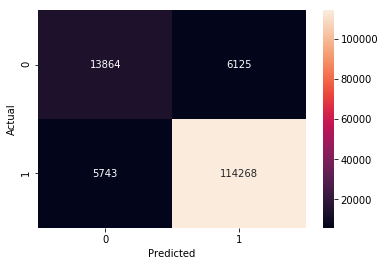

In [22]:
#for train error
y_true, y_pred = y_train, nb_bow.predict(d_train)
print("On train Data :")
print(classification_report(y_true, y_pred))
print()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("The value of TPR is %.3f" %(tp/(fn+tp)) +
      "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
     "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
     "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
print()
print("Train error is %.3f" %((fp+fn)/(1.4*10**3)))
print("The Accuracy Score on Train data is %.3f" %(accuracy_score(y_true, y_pred)*100))

cm=confusion_matrix(y_true, y_pred)
ax=sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='Actual')

On test Data :
             precision    recall  f1-score   support

   negative       0.68      0.64      0.66      8470
   positive       0.94      0.95      0.95     51530

avg / total       0.90      0.91      0.91     60000


The value of TPR is 0.952
The value of TNR is 0.636
The value of FPR is 0.364
The value of FNR is 0.048

Test error is 9.293
The Accuracy Score on Test data is 90.707


[Text(33,0.5,'Actual'), Text(0.5,15,'Predicted')]

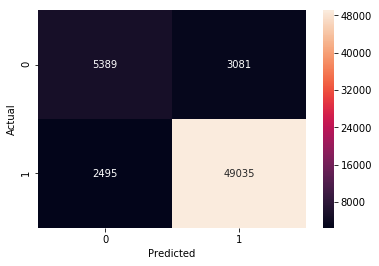

In [23]:
#for test error
y_true, y_pred = y_test, nb_bow.predict(d_test)
print("On test Data :")
print(classification_report(y_true, y_pred))
print()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("The value of TPR is %.3f" %(tp/(fn+tp)) +
      "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
     "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
     "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
print()
print("Test error is %.3f" %((fp+fn)/(0.6*10**3)))
print("The Accuracy Score on Test data is %.3f" %(accuracy_score(y_true, y_pred)*100))

cm=confusion_matrix(y_true, y_pred)
ax=sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='Actual')

### Using Bigrams

In [24]:
import warnings
warnings.filterwarnings('ignore')

#defining alpha for grid-search
param= {'alpha':[0.001,0.01,1,10,100,1000,10000]}

#Using Grid Search to get Best Alpha

clf = GridSearchCV(MultinomialNB(), param, cv=5)
clf.fit(d_train_bg, y_train)
print()
optimal_alpha=clf.best_params_.get('alpha')

In [25]:
nb_gram=MultinomialNB(alpha=optimal_alpha)
nb_gram.fit(d_train_bg,y_train)


MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)

In [26]:
#Saving the model
from sklearn.externals import joblib
joblib.dump(nb_gram, 'nb_bow_gram.pkl') 

['nb_bow_gram.pkl']

In [27]:
#retrieve the model
#nb_gram = joblib.load('nb_bow_gram.pkl')

In [28]:
#Getting 20 most important words in positive reviews
feature_names = count_vect_bg.get_feature_names()
pos = sorted(zip(nb_gram.coef_[0], feature_names))
print(pos[-20:])

[(-6.078512429161581, 'would'), (-6.06795204992892, 'amazon'), (-6.066348434239329, 'eat'), (-6.053131958492189, 'buy'), (-6.046921945519552, 'time'), (-5.908770077013202, 'food'), (-5.7813648402577975, 'get'), (-5.703723772053371, 'make'), (-5.687070961116946, 'coffe'), (-5.591863498088349, 'tri'), (-5.554998568233968, 'product'), (-5.5219204256460905, 'tea'), (-5.471411991809772, 'one'), (-5.421037780738963, 'use'), (-5.391577391802585, 'great'), (-5.380144481270296, 'love'), (-5.351420307686249, 'flavor'), (-5.320085175193604, 'good'), (-5.185009636760295, 'tast'), (-5.123390507148429, 'like')]


In [29]:
#Getting 20 most important words in negative reviews
neg_prob = nb_gram.feature_log_prob_[0, :].argsort()
print(np.take(count_vect_bg.get_feature_names(), neg_prob[-20:]))

['make' 'amazon' 'box' 'even' 'dont' 'tea' 'food' 'order' 'get' 'buy'
 'coffe' 'use' 'good' 'would' 'tri' 'flavor' 'one' 'product' 'like' 'tast']


On train Data :
             precision    recall  f1-score   support

   negative       0.99      0.99      0.99     19989
   positive       1.00      1.00      1.00    120011

avg / total       1.00      1.00      1.00    140000


The value of TPR is 0.999
The value of TNR is 0.993
The value of FPR is 0.007
The value of FNR is 0.001

Train error is 0.197
The Accuracy Score on Train data is 99.803


[Text(33,0.5,'Actual'), Text(0.5,15,'Predicted')]

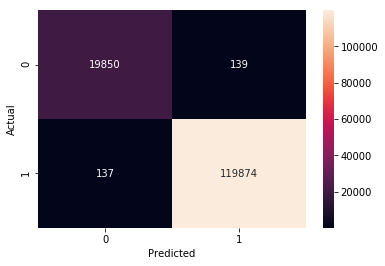

In [30]:
#for train error
y_true, y_pred = y_train, nb_gram.predict(d_train_bg)
print("On train Data :")
print(classification_report(y_true, y_pred))
print()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("The value of TPR is %.3f" %(tp/(fn+tp)) +
      "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
     "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
     "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
print()
print("Train error is %.3f" %((fp+fn)/(1.4*10**3)))
print("The Accuracy Score on Train data is %.3f" %(accuracy_score(y_true, y_pred)*100))

cm=confusion_matrix(y_true, y_pred)
ax=sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='Actual')

On test Data :
             precision    recall  f1-score   support

   negative       0.81      0.37      0.51      8470
   positive       0.91      0.99      0.94     51530

avg / total       0.89      0.90      0.88     60000


The value of TPR is 0.985
The value of TNR is 0.374
The value of FPR is 0.626
The value of FNR is 0.015

Test error is 10.112
The Accuracy Score on Test data is 89.888


[Text(33,0.5,'Actual'), Text(0.5,15,'Predicted')]

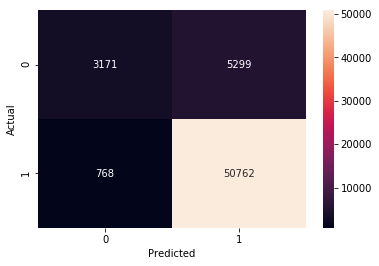

In [31]:
#for test error
y_true, y_pred = y_test, nb_gram.predict(d_test_bg)
print("On test Data :")
print(classification_report(y_true, y_pred))
print()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("The value of TPR is %.3f" %(tp/(fn+tp)) +
      "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
     "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
     "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
print()
print("Test error is %.3f" %((fp+fn)/(0.6*10**3)))
print("The Accuracy Score on Test data is %.3f" %(accuracy_score(y_true, y_pred)*100))

cm=confusion_matrix(y_true, y_pred)
ax=sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='Actual')

# [18.3] TF-IDF

In [32]:
#Build The Vocabulary
tf_idf_vect = TfidfVectorizer()
tf_idf_vect.fit(dw_train['CleanedText'].values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [33]:
#Vectorize train and test data

d_train = tf_idf_vect.transform(dw_train['CleanedText'].values)
print("the type of count vectorizer ",type(d_train))
print("the shape of train-text BOW vectorizer ",d_train.get_shape())

d_test = tf_idf_vect.transform(dw_test['CleanedText'].values)
print("the shape of test-text BOW vectorizer ",d_test.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train-text BOW vectorizer  (140000, 44065)
the shape of test-text BOW vectorizer  (60000, 44065)


### Bi-grams & N-grams ###

In [34]:
##Build The Vocabulary using bi-grams and ngrams
tf_idf_vect_ng = TfidfVectorizer(ngram_range=(1,2))
tf_idf_vect_ng.fit(dw_train['CleanedText'].values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [35]:
#Vectorize train and test data

d_train_ng = tf_idf_vect_ng.transform(dw_train['CleanedText'].values)
print("the type of count vectorizer ",type(d_train))
print("the shape of train-text BOW vectorizer ",d_train_ng.get_shape())

d_test_ng = tf_idf_vect_ng.transform(dw_test['CleanedText'].values)
print("the shape of test-text BOW vectorizer ",d_train_ng.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train-text BOW vectorizer  (140000, 1557089)
the shape of test-text BOW vectorizer  (140000, 1557089)


## [18.3.1] Multinomial Naive Bayes

In [36]:
import warnings
warnings.filterwarnings('ignore')

#defining alpha for grid-search
param= {'alpha':[0.001,0.01,1,10,100,1000,10000]}

#Using Grid Search to get Best Alpha

clf = GridSearchCV(MultinomialNB(), param, cv=5)
clf.fit(d_train, y_train)
print(" optimal value is " + str(clf.best_params_))
print()
optimal_alpha=clf.best_params_.get('alpha')

 optimal value is {'alpha': 0.01}



In [37]:
nb_tfidf=MultinomialNB(alpha=optimal_alpha)
nb_tfidf.fit(d_train,y_train)


MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [38]:
#Saving the model
from sklearn.externals import joblib
joblib.dump(nb_tfidf, 'nb_tfidf.pkl') 

['nb_tfidf.pkl']

In [39]:
#retrieve the model
#nb_tfidf = joblib.load('nb_tfidf.pkl')

In [40]:
#Getting 20 most important words in positive reviews
feature_names = tf_idf_vect.get_feature_names()
pos = sorted(zip(nb_tfidf.coef_[0], feature_names))
print(pos[-20:])

[(-5.718697638973457, 'food'), (-5.692052299839936, 'find'), (-5.6852416491887565, 'amazon'), (-5.666648072675275, 'buy'), (-5.64356417516968, 'price'), (-5.632510311552776, 'best'), (-5.611947248305387, 'get'), (-5.545032632784195, 'make'), (-5.482649622668324, 'tri'), (-5.417117074406126, 'one'), (-5.336961901782471, 'use'), (-5.31620971628724, 'product'), (-5.242023936394497, 'coffe'), (-5.219046419888091, 'flavor'), (-5.159192473698781, 'like'), (-5.149638345480277, 'tea'), (-5.138526013785967, 'tast'), (-5.137242328228577, 'good'), (-5.084276079525077, 'love'), (-5.063082763654018, 'great')]


In [41]:
#Getting 20 most important words in negative reviews
neg_prob = nb_tfidf.feature_log_prob_[0, :].argsort()
print(np.take(tf_idf_vect.get_feature_names(), neg_prob[-20:]))

['bag' 'food' 'even' 'use' 'get' 'dont' 'disappoint' 'good' 'tea' 'box'
 'order' 'buy' 'tri' 'coffe' 'flavor' 'one' 'would' 'product' 'like'
 'tast']


On train Data :
             precision    recall  f1-score   support

   negative       0.95      0.37      0.53     19989
   positive       0.90      1.00      0.95    120011

avg / total       0.91      0.91      0.89    140000


The value of TPR is 0.997
The value of TNR is 0.367
The value of FPR is 0.633
The value of FNR is 0.003

Train error is 9.339
The Accuracy Score on Train data is 90.661


[Text(33,0.5,'Actual'), Text(0.5,15,'Predicted')]

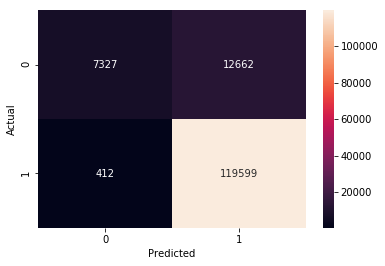

In [42]:
#for train error
y_true, y_pred = y_train, nb_tfidf.predict(d_train)
print("On train Data :")
print(classification_report(y_true, y_pred))
print()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("The value of TPR is %.3f" %(tp/(fn+tp)) +
      "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
     "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
     "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
print()
print("Train error is %.3f" %((fp+fn)/(1.4*10**3)))
print("The Accuracy Score on Train data is %.3f" %(accuracy_score(y_true, y_pred)*100))

cm=confusion_matrix(y_true, y_pred)
ax=sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='Actual')

On test Data :
             precision    recall  f1-score   support

   negative       0.85      0.23      0.36      8470
   positive       0.89      0.99      0.94     51530

avg / total       0.88      0.89      0.86     60000


The value of TPR is 0.993
The value of TNR is 0.231
The value of FPR is 0.769
The value of FNR is 0.007

Test error is 11.438
The Accuracy Score on Test data is 88.562


[Text(33,0.5,'Actual'), Text(0.5,15,'Predicted')]

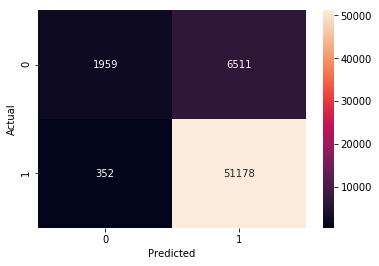

In [43]:
#for test error
y_true, y_pred = y_test, nb_tfidf.predict(d_test)
print("On test Data :")
print(classification_report(y_true, y_pred))
print()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("The value of TPR is %.3f" %(tp/(fn+tp)) +
      "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
     "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
     "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
print()
print("Test error is %.3f" %((fp+fn)/(0.6*10**3)))
print("The Accuracy Score on Test data is %.3f" %(accuracy_score(y_true, y_pred)*100))

cm=confusion_matrix(y_true, y_pred)
ax=sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='Actual')

### Using Bigrams

In [54]:
import warnings
warnings.filterwarnings('ignore')

#defining alpha for grid-search
param= {'alpha':[0.001,0.01,1,10,100,1000,10000]}

#Using Grid Search to get Best Alpha

clf = GridSearchCV(MultinomialNB(), param, cv=10)
clf.fit(d_train_ng, y_train)
print(" optimal value is " + str(clf.best_params_))
optimal_alpha=clf.best_params_.get('alpha')

 optimal value is {'alpha': 0.001}


In [55]:
nb_tfidf_gram=MultinomialNB(alpha=optimal_alpha)
nb_tfidf_gram.fit(d_train_ng,y_train)


MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)

In [56]:
#Saving the model
from sklearn.externals import joblib
joblib.dump(nb_tfidf_gram, 'nb_tfidf_gram.pkl') 

['nb_tfidf_gram.pkl']

In [58]:
#retrieve the model
#nb_tfidf_gram = joblib.load('nb_tfidf_gram.pkl')

In [59]:
#Getting 20 most important words in positive reviews
feature_names = tf_idf_vect_ng.get_feature_names()
pos = sorted(zip(nb_tfidf_gram.coef_[0], feature_names))
print(pos[-20:])

[(-6.820194510244229, 'find'), (-6.816627720581208, 'amazon'), (-6.815778401535542, 'food'), (-6.803241850946741, 'buy'), (-6.7867733479663706, 'price'), (-6.757634626681588, 'best'), (-6.729722915590083, 'get'), (-6.654338864191807, 'make'), (-6.595308105675289, 'tri'), (-6.5318711607591435, 'one'), (-6.448355760995519, 'product'), (-6.443385142405663, 'use'), (-6.354050942358738, 'coffe'), (-6.338428235679675, 'flavor'), (-6.272514887641407, 'like'), (-6.270743200299622, 'good'), (-6.260476281247646, 'tast'), (-6.24171673249576, 'tea'), (-6.221436620566994, 'love'), (-6.205526025658244, 'great')]


In [60]:
#Getting 20 most important words in negative reviews
neg_prob = nb_tfidf_gram.feature_log_prob_[0, :].argsort()
print(np.take(tf_idf_vect_ng.get_feature_names(), neg_prob[-20:]))

['bag' 'even' 'food' 'use' 'get' 'disappoint' 'dont' 'good' 'box' 'tea'
 'buy' 'order' 'tri' 'coffe' 'flavor' 'one' 'would' 'product' 'like'
 'tast']


On train Data :
             precision    recall  f1-score   support

   negative       1.00      0.99      0.99     19989
   positive       1.00      1.00      1.00    120011

avg / total       1.00      1.00      1.00    140000


The value of TPR is 1.000
The value of TNR is 0.991
The value of FPR is 0.009
The value of FNR is 0.000

Train error is 0.149
The Accuracy Score on Train data is 99.851


[Text(33,0.5,'Actual'), Text(0.5,15,'Predicted')]

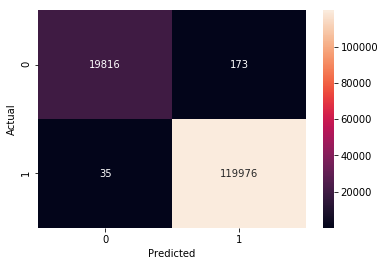

In [61]:
#for train error
y_true, y_pred = y_train, nb_tfidf_gram.predict(d_train_ng)
print("On train Data :")
print(classification_report(y_true, y_pred))
print()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("The value of TPR is %.3f" %(tp/(fn+tp)) +
      "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
     "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
     "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
print()
print("Train error is %.3f" %((fp+fn)/(1.4*10**3)))
print("The Accuracy Score on Train data is %.3f" %(accuracy_score(y_true, y_pred)*100))

cm=confusion_matrix(y_true, y_pred)
ax=sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='Actual')

On test Data :
             precision    recall  f1-score   support

   negative       0.86      0.29      0.43      8470
   positive       0.89      0.99      0.94     51530

avg / total       0.89      0.89      0.87     60000


The value of TPR is 0.992
The value of TNR is 0.290
The value of FPR is 0.710
The value of FNR is 0.008

Test error is 10.693
The Accuracy Score on Test data is 89.307


[Text(33,0.5,'Actual'), Text(0.5,15,'Predicted')]

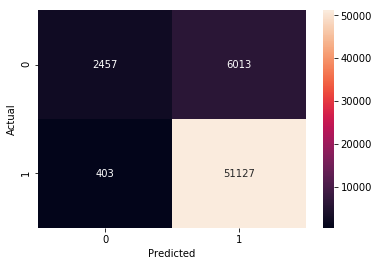

In [62]:
#for test error
y_true, y_pred = y_test, nb_tfidf_gram.predict(d_test_ng)
print("On test Data :")
print(classification_report(y_true, y_pred))
print()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("The value of TPR is %.3f" %(tp/(fn+tp)) +
      "\nThe value of TNR is %.3f" %(tn/(tn+fp)) +
     "\nThe value of FPR is %.3f" %(fp/(tn+fp)) +
     "\nThe value of FNR is %.3f" %(fn/(fn+tp)) )
print()
print("Test error is %.3f" %((fp+fn)/(0.6*10**3)))
print("The Accuracy Score on Test data is %.3f" %(accuracy_score(y_true, y_pred)*100))

cm=confusion_matrix(y_true, y_pred)
ax=sns.heatmap(cm,annot=True,fmt="d")
ax.set(xlabel='Predicted', ylabel='Actual')

### Conclusion ###

In [53]:
from prettytable import PrettyTable
    
pt = PrettyTable()

pt.field_names = ["Vectorising Method", "Optimal Alpha", "Accuracy Score","Precision", "Recall", "F1-Score","Train Error", "Test Error"]

pt.add_row(["Bag Of Words", 1, 90.707, 0.90, 0.91, 0.91, 8.477, 9.293 ])
pt.add_row(["Bag Of Words with n-grams", 0.001, 89.888, 0.89, 0.90, 0.88, 0.197, 10.112])
pt.add_row(["Tf-Idf", 0.01, 88.562, 0.88, 0.89, 0.86, 9.339, 11.438])
pt.add_row(["Tf-Idf with n-grams", 0.001, 89.307, 0.89, 0.89, 0.87, 0.149, 10.693])

print(pt)
print("\n\n Note: Accuracy, Precision, Recall and F1- Score are on Test Data")

+---------------------------+---------------+----------------+-----------+--------+----------+-------------+------------+
|     Vectorising Method    | Optimal Alpha | Accuracy Score | Precision | Recall | F1-Score | Train Error | Test Error |
+---------------------------+---------------+----------------+-----------+--------+----------+-------------+------------+
|        Bag Of Words       |       1       |     90.707     |    0.9    |  0.91  |   0.91   |    8.477    |   9.293    |
| Bag Of Words with n-grams |     0.001     |     89.888     |    0.89   |  0.9   |   0.88   |    0.197    |   10.112   |
|           Tf-Idf          |      0.01     |     88.562     |    0.88   |  0.89  |   0.86   |    9.339    |   11.438   |
|    Tf-Idf with n-grams    |     0.001     |     89.307     |    0.89   |  0.89  |   0.87   |    0.149    |   10.693   |
+---------------------------+---------------+----------------+-----------+--------+----------+-------------+------------+


 Note: Accuracy, Preci

1) The train error is least when we are using *TF-idf (with uni-grams and bi-grams)* for vectorising.

2) Minimum test error is achieved when we are using *Bag of Words (without uni-grams and bi-grams)* for vectorising.

3) Maximum test error is seen when have used *TF-idf (without uni-grams and bi-grams)* for vectorising.

4) The Best Accuracy score is achieved when we have used *Bag of Words (without uni-grams and bi-grams)* for vectorising.

5) The top 20 words (in postive and negative reviews) are same when we are using *uni-grams and bi-grams* and when we are not, in both of the vectorising methods.

6) The difference between test and train error is around 10 when we are using *uni-grams and bi-grams* in both vectorising methods, while the difference is very low when we haven't used *uni-grams and bigrams*. Clearly the model is overfitted due the curse of dimensionality. (have tried to reduce the dimension using TruncatedSVD but due to limited system resources haven't been able to do it)